In [1]:
from pyspark.sql import SparkSession
import happybase
from pyspark import SparkContext
import pandas as pd
import json
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
from pyspark.sql.functions import col, regexp_replace,count,rank
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("HBaseExample") \
    .getOrCreate()

sc = SparkContext.getOrCreate()
connection = happybase.Connection(host='localhost', port=9090)


#### 使用happybase連接Hbase裡面的表格Youbike


In [2]:
# 指定表格名稱和column_family名稱
table_name = 'Youbike'
column_family = 'info'

table = connection.table(table_name)

#### 讀取Hbase裡面的資料並由df變數儲存且轉成dataframe格式


In [3]:
# Fetch data from HBase and create a list of dictionaries
data_list = []
# Scan the entire table and print the data
for key, data in table.scan():
    print(f"Row Key: {key.decode('utf-8')}")
    for column, value in data.items():
        print(f"  {column.decode('utf-8')} : {value.decode('utf-8')}")
    row_dict = {col.decode('utf-8').split(':')[1]: data[col].decode('utf-8') for col in data}
    #因為sno在hbase為row key
    row_dict['sno'] = key.decode('utf-8')
    data_list.append(row_dict)
    
df = spark.createDataFrame(data_list)

Row Key: 500101001
  info:act : 1
  info:ar : 復興南路二段235號前
  info:aren : No.235， Sec. 2， Fuxing S. Rd.
  info:bemp : 25
  info:infoDate : 2024-01-03
  info:infoTime : 2024-01-03 15:19:06
  info:lat : 25.02605
  info:lng : 121.5436
  info:mday : 2024-01-03 15:19:06
  info:sarea : 大安區
  info:sareaen : Daan Dist.
  info:sbi : 3
  info:sna : YouBike2.0_捷運科技大樓站
  info:snaen : YouBike2.0_MRT Technology Bldg. Sta.
  info:srcUpdateTime : 2024-01-03 15:20:56
  info:tot : 28
  info:updateTime : 2024-01-03 15:21:08
Row Key: 500101002
  info:act : 1
  info:ar : 復興南路二段273號西側
  info:aren : No.273， Sec. 2， Fuxing S. Rd. (West)
  info:bemp : 20
  info:infoDate : 2024-01-03
  info:infoTime : 2024-01-03 15:19:06
  info:lat : 25.02565
  info:lng : 121.54357
  info:mday : 2024-01-03 15:19:06
  info:sarea : 大安區
  info:sareaen : Daan Dist.
  info:sbi : 1
  info:sna : YouBike2.0_復興南路二段273號前
  info:snaen : YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.
  info:srcUpdateTime : 2024-01-03 15:20:56
  info:tot : 21
  inf

主要欄位說明 : 
sno(站點代號)、sna(場站中文名稱)、tot(場站總停車格)、sbi(場站目前車輛數量)、sarea(場站區域)、mday(資料更新時間)、lat(緯度)、lng(經度)、ar(地點)、sareaen(場站區域英文)、snaen(場站名稱英文)、aren(地址英文)、bemp(空位數量)、act(全站禁用狀態)、srcUpdateTime(YouBike2.0系統發布資料更新的時間)、updateTime(大數據平台經過處理後將資料存入DB的時間)、infoTime(各場站來源資料更新時間)、infoDate(各場站來源資料更新時間)

#### 計算前10最熱門的租借點

In [4]:
# Extract relevant columns
selected_columns = ["sno","sna", "sarea", "mday", "sbi"]
df_selected = df.select(selected_columns)


# 將 "sna" 列中的 "YouBike2.0" 字樣替換為空字符串
df_selected = df_selected.withColumn("sna", regexp_replace(col("sna"), "YouBike2.0_", ""))

# Convert timestamp to hour
df_selected = df_selected.withColumn("hour", col("mday").substr(12, 2))
# Aggregate data by hour, station ID, and area
agg_df = df_selected.groupBy("hour","sno", "sna", "sarea").agg({"sbi": "sum"}).withColumnRenamed("sum(sbi)", "total_bikes")

In [5]:
windowSpec = Window.partitionBy("hour").orderBy(col("total_bikes").desc())
ranked_df = agg_df.withColumn("rank", rank().over(windowSpec))

# Filter the top 10 stations for each hour
top_10_df = ranked_df.filter(col("rank") <= 10)

print("The top 10 busiest stations/areas every hour")

# Show the results
top_10_df.show()

The top 10 busiest stations/areas every hour


+----+---------+---------------------------+------+-----------+----+
|hour|      sno|                        sna| sarea|total_bikes|rank|
+----+---------+---------------------------+------+-----------+----+
|  15|500104031|               劍潭基河路口|士林區|       56.0|   1|
|  15|500107028|    捷運松江南京站(7號出口)|中山區|       55.0|   2|
|  15|500108022|               洲子二號公園|內湖區|       55.0|   2|
|  15|500107024|             捷運中山國中站|中山區|       53.0|   4|
|  15|500110014|               民生敦化路口|松山區|       51.0|   5|
|  15|500107012|               復興市民路口|中山區|       48.0|   6|
|  15|500112082|             臺北南山廣場_1|信義區|       46.0|   7|
|  15|500112043|               興雅松仁路口|信義區|       46.0|   7|
|  15|500101115|         建國和平路口西北側|大安區|       45.0|   9|
|  15|500110005|                   中崙高中|松山區|       40.0|  10|
|  15|500112076|捷運台北101/世貿站(2號出口)|信義區|       40.0|  10|
+----+---------+---------------------------+------+-----------+----+



#### 計算站點數量和分佈 sareaen(場站名稱英文)

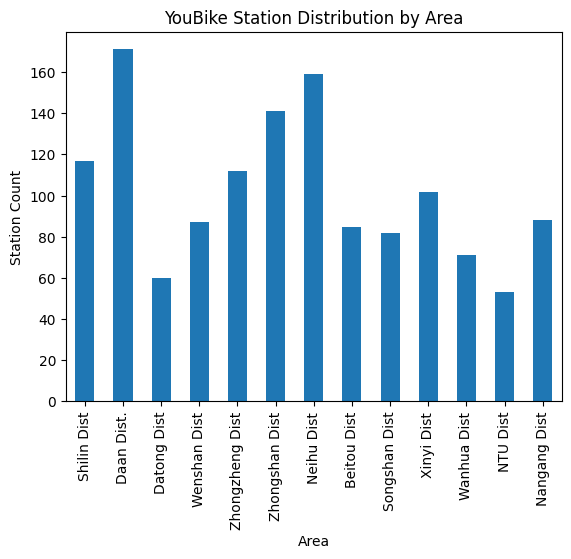

In [6]:
area_counts = df.groupBy("sareaen").agg(count("sno").alias("station_count"))

# 將結果轉換為 Pandas DataFrame，以便使用 Matplotlib 繪圖
area_counts_pd = area_counts.toPandas()

# 繪製長條圖
area_counts_pd.plot(kind="bar", x="sareaen", y="station_count", legend=False)
plt.title("YouBike Station Distribution by Area")
plt.xlabel("Area")
plt.ylabel("Station Count")
plt.show()

#### 分析站點的平均車輛數量（sbi）

In [7]:
from pyspark.sql.functions import mean, stddev
# 計算各站點的車輛數量統計信息
sbi_stats = df.groupBy(["sno","sna"]).agg(mean("sbi").alias("average_sbi"))
sbi_stats.show()

+---------+--------------------------+-----------+
|      sno|                       sna|average_sbi|
+---------+--------------------------+-----------+
|500101136|YouBike2.0_信義大安路口...|        6.0|
|500103037|       YouBike2.0_太原廣場|       28.0|
|500103055|   YouBike2.0_承德昌吉街口|        4.0|
|500104056|       YouBike2.0_社正公園|        5.0|
|500101022| YouBike2.0_捷運公館站(...|        5.0|
|500101116|       YouBike2.0_金華公園|       20.0|
|500104062|       YouBike2.0_泰北高中|        3.0|
|500104074|       YouBike2.0_蘭雅國小|       14.0|
|500101004|   YouBike2.0_和平公園東側|        5.0|
|500101033|   YouBike2.0_臺大男六舍前|       38.0|
|500101143|       YouBike2.0_昌隆公園|       14.0|
|500101207|YouBike2.0_捷運臺電大樓...|       16.0|
|500104044|       YouBike2.0_蘭雅公園|       15.0|
|500103012|YouBike2.0_重慶北路三段...|        3.0|
|500104079|  YouBike2.0_東山路110巷口|        4.0|
|500101122|YouBike2.0_敦化南路二段...|        0.0|
|500103050|   YouBike2.0_太原五原路口|        7.0|
|500101150|YouBike2.0_捷運忠孝新生...|        1.0|
|500103060|       You

主要欄位說明 : sno(站點代號)、sna(場站中文名稱)、average_sbi(平均車輛數量)

#### 計算站點總停車格利用率（sbi/tot）

In [8]:
# 計算站點總停車格利用率
df_utilization = df.withColumn("utilization_rate", col("sbi") / col("tot"))

df_utilization = df_utilization.select(["sno","sna", "sarea", "tot", "sbi","utilization_rate"])
df_utilization.show()

+---------+-----------------------------+------+---+---+--------------------+
|      sno|                          sna| sarea|tot|sbi|    utilization_rate|
+---------+-----------------------------+------+---+---+--------------------+
|500101001|    YouBike2.0_捷運科技大樓站|大安區| 28|  3| 0.10714285714285714|
|500101002|   YouBike2.0_復興南路二段...|大安區| 21|  1|0.047619047619047616|
|500101003|YouBike2.0_國北教大實小東側門|大安區| 16|  1|              0.0625|
|500101004|      YouBike2.0_和平公園東側|大安區| 11|  5| 0.45454545454545453|
|500101005|YouBike2.0_辛亥復興路口西北側|大安區| 16| 10|               0.625|
|500101006|   YouBike2.0_復興南路二段...|大安區| 11|  2| 0.18181818181818182|
|500101007|   YouBike2.0_復興南路二段...|大安區| 11|  3|  0.2727272727272727|
|500101008|   YouBike2.0_新生南路三段...|大安區| 17|  2| 0.11764705882352941|
|500101009|   YouBike2.0_新生南路三段...|大安區| 16|  4|                0.25|
|500101010|   YouBike2.0_新生南路三段...|大安區| 20|  4|                 0.2|
|500101012|  YouBike2.0_辛亥路一段30號前|大安區|  8|  1|               0.125|
|500101013|YouB

主要欄位說明 : sno(站點代號)、sna(場站中文名稱)、tot(場站總停車格)、sbi(場站目前車輛數量)、sarea(場站區域)、utilization_rate(站點總停車格利用率)

#### 分析站點的空位數量（bemp）

In [9]:
average_bemp = df.selectExpr("avg(bemp) as average_bemp").collect()[0]["average_bemp"]
average_bemp

13.662650602409638

#### 找出哪些站點經常有空位

In [10]:
df_bemp_above_average = df.filter(col("bemp") > average_bemp)
df_bemp_above_average= df_bemp_above_average.select(["sno","sna", "sarea", "bemp"])
df_bemp_above_average.show()

+---------+-----------------------------+------+----+
|      sno|                          sna| sarea|bemp|
+---------+-----------------------------+------+----+
|500101001|    YouBike2.0_捷運科技大樓站|大安區|  25|
|500101002|   YouBike2.0_復興南路二段...|大安區|  20|
|500101003|YouBike2.0_國北教大實小東側門|大安區|  15|
|500101008|   YouBike2.0_新生南路三段...|大安區|  15|
|500101010|   YouBike2.0_新生南路三段...|大安區|  16|
|500101022|    YouBike2.0_捷運公館站(...|大安區|  94|
|500101023|  YouBike2.0_第二學生活動中心|大安區|  22|
|500101024|  YouBike2.0_臺灣科技大學正門|大安區|  17|
|500101025|  YouBike2.0_臺灣科技大學側門|大安區|  64|
|500101027|  YouBike2.0_臺灣科技大學後門|大安區|  21|
|500101031|      YouBike2.0_臺大男七舍前|大安區|  15|
|500101032|      YouBike2.0_臺大男一舍前|大安區|  41|
|500101037|YouBike2.0_臺大國青大樓宿舍前|大安區|  17|
|500101040|   YouBike2.0_臺大綜合體育...|大安區|  21|
|500101041|YouBike2.0_辛亥新生路口東南側|大安區|  36|
|500101095|          YouBike2.0_芳和國中|大安區|  18|
|500101097|      YouBike2.0_臥龍樂業街口|大安區|  30|
|500101099|          YouBike2.0_嘉興公園|大安區|  27|
|500101100|    YouBike2.0_捷運麟光站(...|大安區| 

#### 找出哪些站點經常沒有空位

In [11]:
df_bemp_below_average = df.filter(col("bemp") < average_bemp)
df_bemp_below_average= df_bemp_below_average.select(["sno","sna", "sarea", "bemp"])
df_bemp_below_average.show()

+---------+-----------------------------+------+----+
|      sno|                          sna| sarea|bemp|
+---------+-----------------------------+------+----+
|500101004|      YouBike2.0_和平公園東側|大安區|   6|
|500101005|YouBike2.0_辛亥復興路口西北側|大安區|   6|
|500101006|   YouBike2.0_復興南路二段...|大安區|   9|
|500101007|   YouBike2.0_復興南路二段...|大安區|   8|
|500101009|   YouBike2.0_新生南路三段...|大安區|  12|
|500101012|  YouBike2.0_辛亥路一段30號前|大安區|   7|
|500101013|YouBike2.0_和平復興路口西北側|大安區|   9|
|500101014|   YouBike2.0_羅斯福路三段...|大安區|   2|
|500101015|YouBike2.0_大安運動中心停車場|大安區|  11|
|500101016|   YouBike2.0_羅斯福路三段...|大安區|   4|
|500101018|          YouBike2.0_溫州公園|大安區|   1|
|500101019|      YouBike2.0_和平臥龍街口|大安區|   0|
|500101020|        YouBike2.0_溫州停車場|大安區|   5|
|500101021|      YouBike2.0_銘傳國小側門|大安區|   5|
|500101026|          YouBike2.0_公館公園|大安區|   7|
|500101028|   YouBike2.0_臺大醫學院附...|大安區|  11|
|500101029|      YouBike2.0_臺大環研大樓|大安區|   1|
|500101030|YouBike2.0_臺大永齡生醫工程館|大安區|   2|
|500101033|      YouBike2.0_臺大男六舍前|大